# Integrated Project

I work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. I need to identify patterns that determine whether a game succeeds or not. This will allow me to spot potential big winners and plan advertising campaigns.

let's get down to business.

importing libraries:

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats as st
import sidetable as stb
from statistics import mode
import nums_from_string as nfs

reading the csv:

In [3]:
try:
    data = pd.read_csv('C:\\Users\\aviv\\Downloads\\practicum100\\games.csv')
except:
    data = pd.read_csv('/datasets/games.csv')

In [4]:
data.sample(7)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
7119,New Carnival Games,DS,2010.0,Misc,0.16,0.05,0.00,0.02,NaN,tbd,E
472,Epic Mickey,Wii,2010.0,Platform,2.04,0.63,0.12,0.22,73.0,7,E
5932,Shrek the Third,DS,NaN,Action,0.26,0.01,0.00,0.02,70.0,6.5,E
2609,Sniper: Ghost Warrior,PS3,2011.0,Shooter,0.27,0.34,0.04,0.13,53.0,6,M
11348,The Secret Saturdays: Beasts of the 5th Sun,DS,2009.0,Action,0.08,0.00,0.00,0.01,60.0,tbd,E10+
9845,IndyCar Series,PS2,2003.0,Racing,0.06,0.05,0.00,0.02,69.0,tbd,E
9840,Greg Hastings Paintball 2,Wii,2010.0,Shooter,0.11,0.00,0.00,0.01,NaN,tbd,E10+


## Preprocessing

In [15]:
data.describe()

lowercasing the column names:

In [16]:
data.columns=data.columns.str.lower()
data

In [21]:
data=data.rename(columns = {'year_of_release':'year'})
data

In [17]:
data.info()

data types that could be changed:

-user_score, critic score and year to float64


in order for it to be easier to manipulate and calculate means and such.

missing data:
 

In [18]:
data.stb.missing(style=True)

In [22]:
data[data['critic_score'].isnull()]
data[data['critic_score'].isnull()]['year'].value_counts()
data[data['year'].isnull()]

possible explanations:
critic score and rating, user score - some games are really old and probably didn't get a review from a (what we consider today) respectable game reviewer, or the ESRB. some of the games are recent, possibly they are ports from one platform to another and don't need a new rating. user score, same deal.

year of release - seems the year is missing for games from several periods (i can see from the titles and platforms), which leads me to believe the problem is technical like a server problem or other data gathering problem. will fill by group modes, and when that doesn't work fill zeroes and change to float.



In [23]:
data.loc[data['year'].isna(),'year']

let's fill year missing values:

In [24]:
data.loc[data['name'].isna()]=data.loc[data['name'].isna()].fillna('unidentified')
data.loc[data['name'].isna()]

data['filled_year'] = data.groupby('name')['year'].transform(lambda grp: grp.fillna(mode(grp)) )
data.loc[data['year'].isna(),'year']=data['filled_year']

In [25]:
data.loc[data['year'].isna(),['name','year']]

In [26]:
#data.loc[(data['year'].isna()]
data['possible_year']=data.loc[data['year'].isna(),'name'].transform(nfs.get_nums)
data['possible_year'].value_counts()

TypeError: unhashable type: 'list'

there's really not many games with years in their name, i'm not gonna bother with filling those in.

In [27]:
data['year']=data['year'].fillna(0).astype(float)

In [28]:
data.info()

In [29]:
data.describe(include=object)

calculating total sales:

In [30]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.sample(7)

In [31]:
good_data = data.loc[data['critic_score'].notna()].query("critic_score not in ['tbd','unidentified']")
good_data['critic_score'] = good_data['critic_score'].astype(float)

good_data = good_data.loc[data['user_score'].notna()].query("user_score not in ['tbd','unidentified']")
good_data['user_score'] = good_data['user_score'].astype(float)

good_data.sample(5)

we're ready to analyze!

## Analysis

#### Period Comparison
let's compare how many games came out in different time periods.

In [32]:
df = data.query("year!=0")[['year','name']].groupby(['year']).count().sort_values(by='year').reset_index()
df

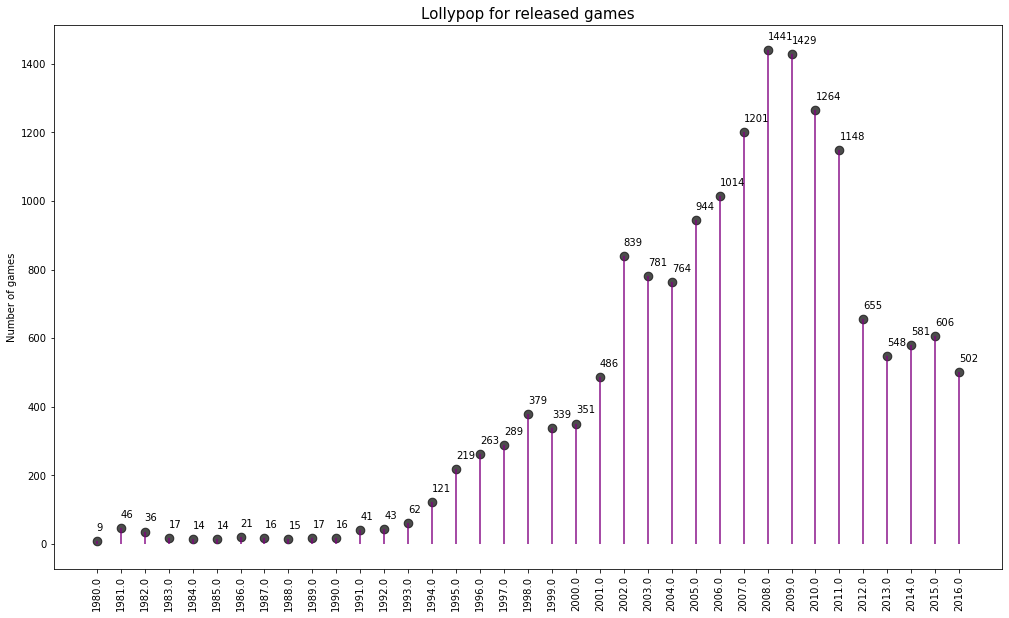

In [33]:
fig, ax = plt.subplots(figsize=(17,10))
ax.vlines(x=df.year, ymin=0, ymax=df.name, color = 'purple', alpha=0.7, linewidth=2)
ax.scatter(x=df.year,y=df.name, s=75, color='black', alpha=0.7)
ax.set_title("Lollypop for released games", fontdict={'size':15})
ax.set_ylabel('Number of games')
ax.set_xticks(df.year)
ax.set_xticklabels(df.year,rotation=90)

for row in df.itertuples():
    ax.text(row.year, row.name+30, s=round(row.name, 2))

looks like until 1995 there wasn't a significant amount of games being released yearly, the video game industry was still in it's infancy. sales rose until 2008, declined a bit until 2013, then rose again until 2015. and as for our analysis we'll definitely look at more recent years like 2011 onward.

#### Platform Sales Comparison

let's group by platform and sum up the total sales.

In [34]:
df=data[['platform', 'total_sales']].groupby(['platform']).sum().sort_values(by='total_sales', ascending=False).reset_index()
df

In [35]:
df['sales_z']=(df['total_sales']-df['total_sales'].mean())/df['total_sales'].std()
df['color']=['red' if x<0 else 'green' for x in df['sales_z']]
df

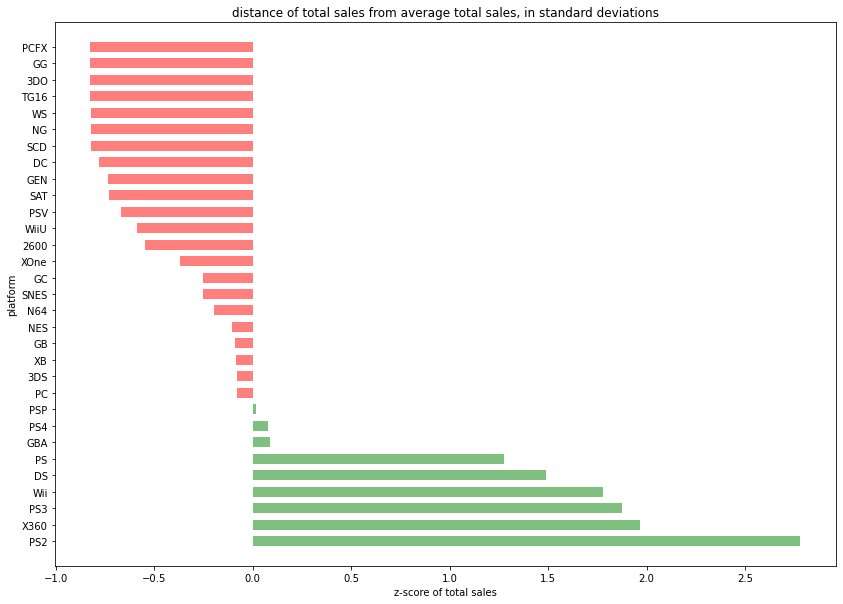

In [42]:
plt.figure(figsize=(14,10))
plt.ylabel('platform')
plt.xlabel('z-score of total sales')
plt.title('distance of total sales from average total sales, in standard deviations')
plt.hlines(y=df.platform, xmax=df.sales_z,xmin=0,color=df.color, alpha=0.5, linewidth=10) 

looks like the ps2 is an alltime favorite. let's pick the top 5 of all time and build distributions based on data for each year.

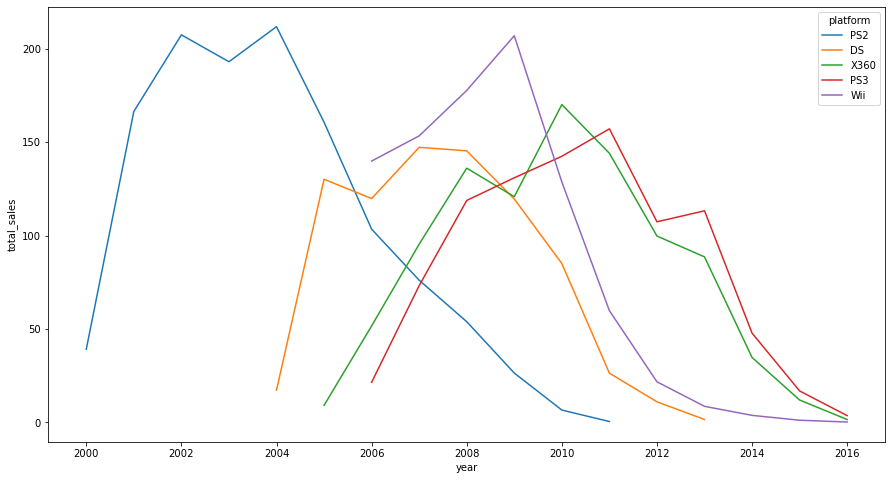

In [390]:
top_platforms = data.query("platform in ['PS2','X360','PS3','Wii','DS'] and year>1990") #top of all time
df = top_platforms.groupby(['platform','year'])['total_sales'].sum().reset_index().sort_values(by='year')

plt.figure(figsize=(15,8))
ax = sns.lineplot(data=df, x='year', y='total_sales', hue='platform')





everything has to end. almost all the top consoles zero out eventually.

as the technology evolves, so do the players and their standards.

let's look at approximate "ages" for the consoles:

In [391]:
df=df.groupby(['platform'])['year'].agg(['min','max']).reset_index()
df

In [392]:
df['age'] = df['max'] - df['min']
df

looks like even the best sellers survive for only about 10 years.

for the rest of our analysis we'll look at more recent years, 2012 onward so we include only the more modern consoles.

In [393]:
platform_sales = data.query("year > 2011").groupby('platform')['total_sales'].sum().reset_index()
platform_sales.sort_values(by='total_sales',ascending = False)

#### Top selling platforms in the last 5 years

narrowing to 5 top best selling platforms in the last 5 years:

In [394]:
df = data.query("(platform in ['PS4','PS3','X360','3DS','XOne']) and (year>2011)")
df = df.groupby(['platform','year'])['total_sales'].sum().reset_index().sort_values(by='total_sales',ascending=False)
df


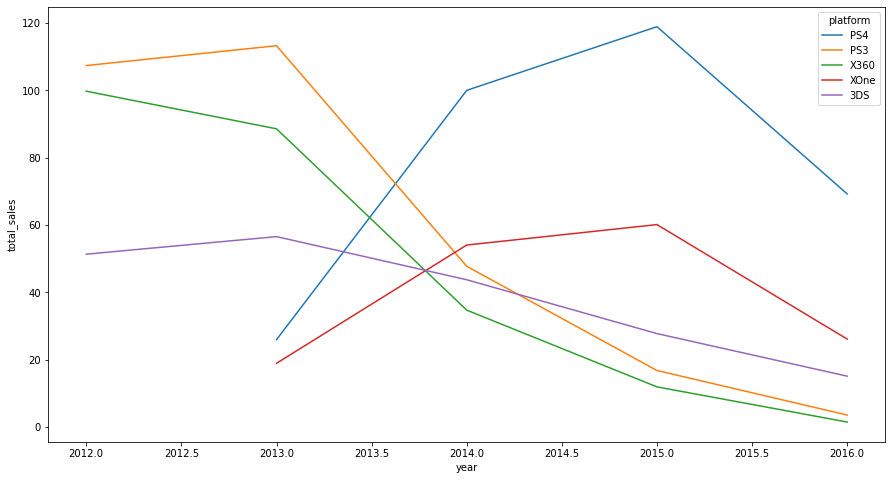

In [395]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(data=df, x='year', y='total_sales', hue='platform')

PS4 is leading in the last 5 years, declining in the last year perhaps because the data for 2016 is incomplete
Xbox one could also be said to be gaining popularity. but all the others are visibly declining.

if i had to pick i'd definitely go with the modern and powerful consoles like PS4 and XOne who are the only ones still showing signs of growth, but also notice the 3DS as the leader of handheld sales.

In [43]:
df=data.query("year>2011").pivot_table(index='year', columns='platform', values='total_sales',aggfunc='sum',fill_value=0)
df

In [44]:
dynamics=(df-df.shift(+1)).T
dynamics

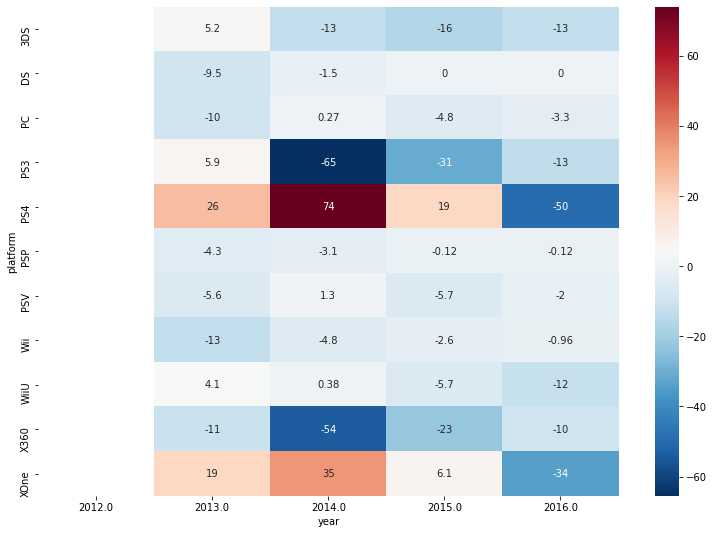

In [46]:
plt.figure(figsize=(13,9))
sns.heatmap(dynamics, cmap='RdBu_r', annot=True)

this is a heatmap of yearly rise/fall in sales per console. each line tells a story of one console

#### global sales of all games broken down by platform

plotting box plots:

In [47]:
df = data.query("year>2011").groupby(['platform','name'])['total_sales'].sum().reset_index()
df

In [48]:
order=df.groupby(['platform'])['total_sales'].sum().reset_index().sort_values(by='total_sales')['platform']
order

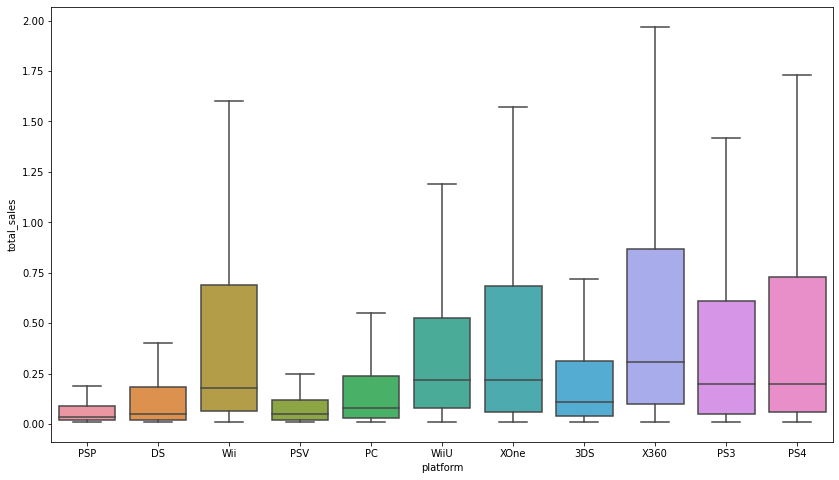

In [49]:
plt.figure(figsize=(14,8))
ax=sns.boxplot(x="platform", y="total_sales",order=order, data=df,showfliers = False)

let's talk about the differences between the handhelds (PSV, PSP, DS, 3DS) the 3DS has the longest box, which means the variance is very high. its median is the highest and the section above the median also largest. 3DS dominates the handhelds. also highest whisker of the handhelds.

as for the rest (home consoles) clearly X360 is the winner with very high variability and median and upper whisker. although just slightly better than PS4, PS3, XOne and Wii.

#### Sales Compared by User and Professional Reviews

let's look at the leader in recent game sales, the PS4 and see how user and professional reviews affect sales.

In [50]:
good_data.query("platform=='PS4'").groupby(['critic_score'])['total_sales'].sum().reset_index().sort_values(by='critic_score',ascending=False)

good_data.query("platform=='PS4'").pivot_table(index='critic_score',values='total_sales',aggfunc='sum').sort_values(by='total_sales',ascending=False)

we see that the best sold games have a pretty good critic score, but not the best scores! interesting isn't it?

my explanation is that the best sold games appeal to a wider audience (FIFA soccer games, regular old fighting games like TEKKEN) and they're really games that stick to a formula. and when you don't innovate, you don't get a high score.
the really polished games and those who a lot of thought was put into, they get the higher scores but they don't appeal to everyone, so they get lower sales.

another explanation would be that the best selling games are more polarizing, as in they get both really good and really bad reviews, for example a critic could say a game is not living up to its hype.

In [402]:
good_data.query("platform=='PS4'").pivot_table(index='user_score',values='total_sales',aggfunc='sum').sort_values(by='user_score',ascending=False)
good_data.query("platform=='PS4'").pivot_table(index='user_score',values='total_sales',aggfunc='sum').sort_values(by='total_sales',ascending=False)

wow the best sellers have a REALLY low user rating! i would explain this by saying most people don't bother looking at what other users are saying about games, they either buy the games blindly based on their uneducated expectation of the game or just based on critic ratings.

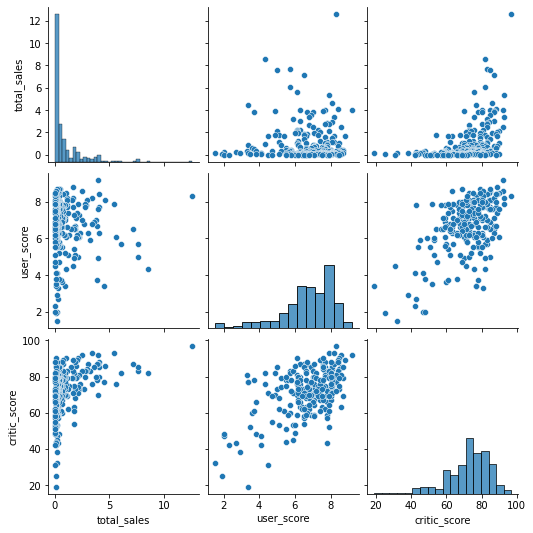

In [403]:

for_corr = good_data.query("platform=='PS4'")[['total_sales','user_score','critic_score']]
sns.pairplot(for_corr)

In [404]:
for_corr.corr()

we see that user score correlates inversly but poorly. people definitely don't pay attention to user scores when they buy games. the critic score correlates weakly.

let's check for other modern consoles:

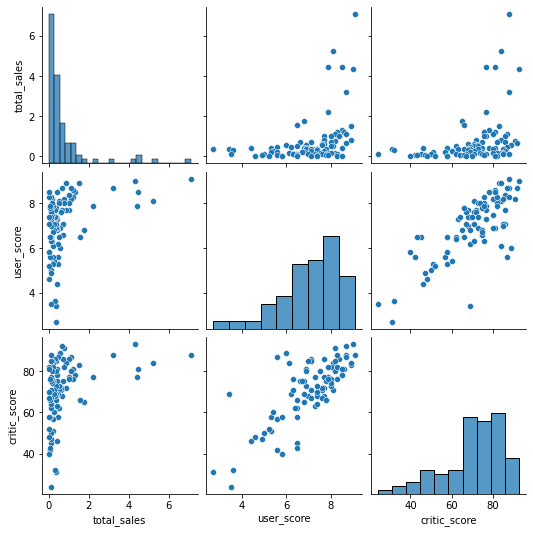

In [405]:

             
for_corr = good_data.query("platform=='WiiU'")[['total_sales','user_score','critic_score']]
print(" WiiU sales compared by critic and user reviews")
sns.pairplot(for_corr)

In [406]:
for_corr.corr()

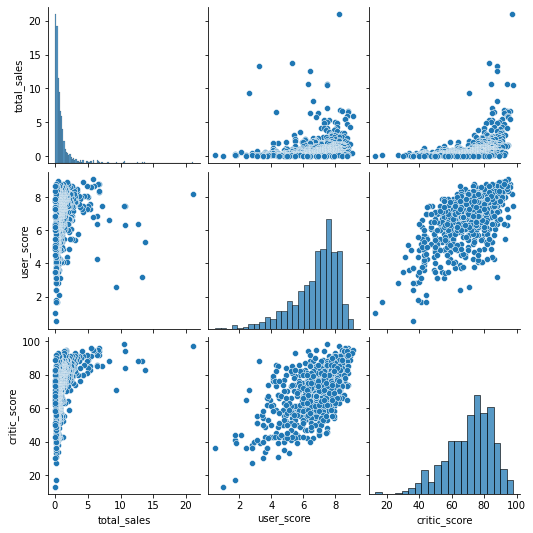

In [407]:
for_corr = good_data.query("platform=='PS3'")[['total_sales','user_score','critic_score']]
print(" PS3 sales compared by critic and user reviews")
sns.pairplot(for_corr)


In [408]:
for_corr.corr()

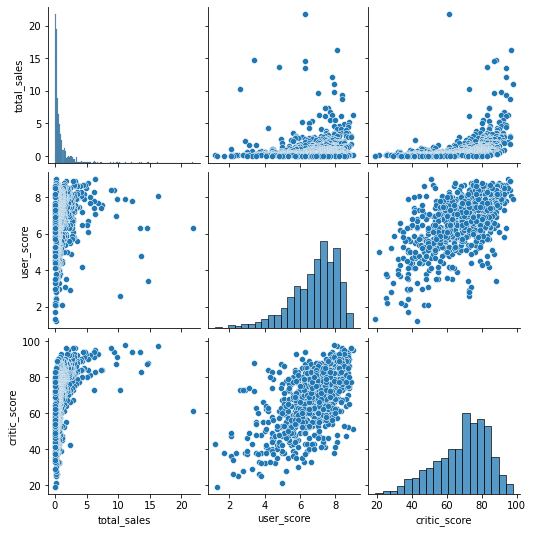

In [409]:
for_corr = good_data.query("platform=='X360'")[['total_sales','user_score','critic_score']]
print(" X360 sales compared by critic and user reviews")
sns.pairplot(for_corr)

In [410]:
for_corr.corr()

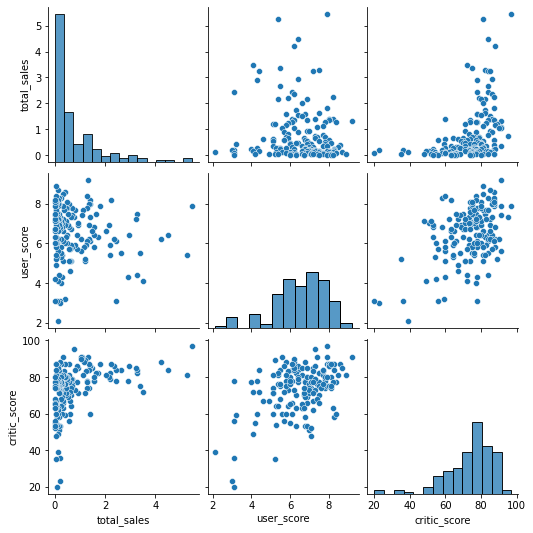

In [411]:
for_corr = good_data.query("platform=='XOne'")[['total_sales','user_score','critic_score']]
print(" XOne sales compared by critic and user reviews")
sns.pairplot(for_corr)

In [412]:
for_corr.corr()

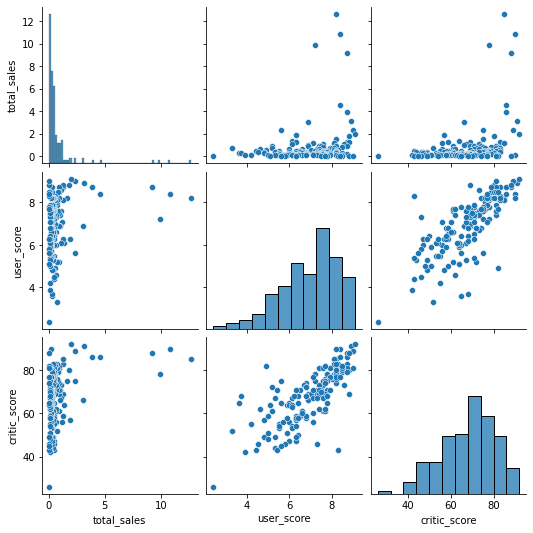

In [413]:
for_corr = good_data.query("platform=='3DS'")[['total_sales','user_score','critic_score']]
print(" 3DS sales compared by critic and user reviews")
sns.pairplot(for_corr)

In [414]:
for_corr.corr()

the reviews more or less correlate weakly across all the modern consoles.

distribution of games by genre:

In [415]:
df=data[['total_sales','genre']].groupby(['genre']).sum().reset_index().sort_values(by='total_sales',ascending=False)
df

nothing surprising here. action, sports, and role-playing are leaders (i consider shooter like action)

you could say the lower sales genre are 'brainier' like puzzles, simulation, strategy.
and the higher sales genres are more 'in-your-face' and to the point.

# User Profiling
top five platforms:

In [416]:
na=data.query("year>2011").groupby(['platform'])['na_sales'].sum().reset_index().sort_values(by='na_sales',ascending=False).head()
na

in america X360 leads, it's american made!

In [417]:
jp=data.query("year>2011").groupby(['platform'])['jp_sales'].sum().reset_index().sort_values(by='jp_sales',ascending=False).head()
jp

japanese love their handhelds, and their nintendo! no microsoft made is even on the top 5

In [418]:
eu=data.query("year>2011").groupby(['platform'])['eu_sales'].sum().reset_index().sort_values(by='eu_sales',ascending=False).head()
eu

interesting, here we have both japanese and american made in the top five.

top five genres:

In [419]:
na=data.query("year>2011").groupby(['genre'])['na_sales'].sum().reset_index().sort_values(by='na_sales',ascending=False).head()
na

In [420]:
na=data.query("year>2011").groupby(['genre'])['jp_sales'].sum().reset_index().sort_values(by='jp_sales',ascending=False).head()
na

In [421]:
na=data.query("year>2011").groupby(['genre'])['eu_sales'].sum().reset_index().sort_values(by='eu_sales',ascending=False).head()
na

i have to say, it's really amazing to see that RPG is leading in sales in japan. they are the kings of RPG!

perhaps the japanese chase the feeling of being immersed in another world, as a different character, as opposed to the americans and europeans who generally just want to blow off some steam and shoot stuff.

In [422]:
na=data.query("year>2011").groupby(['rating'])['na_sales'].sum().reset_index().sort_values(by='na_sales',ascending=False).head()
na

In [423]:
na=data.query("year>2011").groupby(['rating'])['jp_sales'].sum().reset_index().sort_values(by='jp_sales',ascending=False).head()
na

In [424]:
na=data.query("year>2011").groupby(['rating'])['eu_sales'].sum().reset_index().sort_values(by='eu_sales',ascending=False).head()
na

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

You could also try to use pie-charts here to improve your project) 
    
But it's not a mistake, and your conclusions below are good. 

</div>

we see that mature rated games lead the sales both in american and european markets, with 'everyone' rated games coming in second. in japan E rated are first. my wild guess is that because the age restrictions are more severely enforced in japan than in the western audiences. for example; a western parent might buy their kid GTAV which is rated M for mature thinking it couldn't do much harm, whereas a japanese parent won't do the same.

Profiles:

american gamer - on average prefers X360 or PS4, plays Shooters, action and sports games, and prefers Mature rated games.

japanese gamer - on average prefers japanese made platforms, 3DS PS3 leading, mainly plays RPG, action games and others
and doesn't prefer M rated, instead going for 'Everyone' rated.

european gamer - on average prefers PS4, PS3, and X360. plays action, shooters, and sports games exactly like the average american. looks like no age rating preference either, like the japanese gamer.

# Testing Hypotheses

H0: average user ratings of the Xbox One and PC platforms are the same.

H1: average user ratings of XOne and PC differ

######

H0': average user ratings for action and sports genre are the same

H1': average user ratings for action and sports differ


we'll use alpha of 5% as usual.

In [267]:
df=good_data[['platform','user_score']].query("platform in ['XOne','PC']")

df_pc=good_data[['platform','user_score']].query("platform=='PC'")

df_xo=good_data[['platform','user_score']].query("platform=='XOne'")

In [271]:
print("variance for PC user ratings:", np.var(df_pc['user_score']))
print("variance for XOne user ratings:", np.var(df_xo['user_score']))
print("the variance is similar so we can check the different variances as a hypothesis. our null hypothesis")
print("is that the variances are equal")

st.levene(df_pc['user_score'], df_xo['user_score'], center='mean')



Pvalue is small enough to reject null hypothesis, therefore variances are different and we can set equal_var parameter to false

In [274]:
alpha = 0.05  # critical statistical significance level
# if the p-value is less than alpha, we reject the hypothesis

result1 = st.ttest_ind(
    df_pc['user_score'], df_xo['user_score'], equal_var=False)
print('p-value: ', result1.pvalue)
if result1.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")
    
print("pc user ratings mean:", df_pc['user_score'].mean())
print("XOne user ratings mean:", df_xo['user_score'].mean())

that means we can say the average user ratings on PC and XOne are different.

In [282]:
df_action=good_data[['genre','user_score']].query("genre=='Action'")


df_sports=good_data[['genre','user_score']].query("genre=='Sports'")
df_sports

In [286]:
print("variance for action genre user ratings:", np.var(df_action['user_score']))
print("variance for sports genre user ratings:", np.var(df_sports['user_score']))
print("the variance is similar so we can check the different variances as a hypothesis. our null hypothesis")
print("is that the variances are equal")

st.levene(df_action['user_score'], df_sports['user_score'], center='mean')

Pvalue is small enough to conclude the variances are different. we'll set equal_var=False

In [287]:
alpha = 0.05  # critical statistical significance level
# if the p-value is less than alpha, we reject the hypothesis

result1 = st.ttest_ind(
    df_action['user_score'], df_sports['user_score'], equal_var=False)
print('p-value: ', result1.pvalue)
if result1.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")
    
print("action genre user ratings mean:", df_action['user_score'].mean())
print("sports genre user ratings mean:", df_sports['user_score'].mean())

so we can conclude the average ratings are the same across action and sports.

# Conclusions

## Preprocessing stage

- we've lowercased the column names
- converted year, user and critic scores to floats
- filled in missing year values based on modes of grouped data by name. a small amount could've been filled by accessing the numbers in the name strings, but for such a small amount (about 10 titles) it wasn't worth the effort.
- the missing values were missing at random, so some data gathering problem or server problem.
- TBD ratings were impossible to handle, as there's no way to know ratings (we don't even know how the ratings were gathered) so were dropped when the scores were analyzed
- total sales for each game calculated into 'total_sales' column.

## Analysis stage

- we saw that the yearly number of games released wasn't significant until about 1995, and decided to use mainly 2012 onward for analysis. also, the video gaming industry could have declined slightly in recent years because of the rise of smartphone gaming, or perhaps because the small time (or low budget, or indie) developers made the transition to smartphone gaming or just died out. 
- we saw that for the most succesful platforms of the last few years, the median lifespan is about 10 years, and they all die out eventually.
- the PS4, XOne and 3DS had the highest total sales in 2015. i'd pick them as the most profitable. as for the 3DS, it is nearing the end of its lifespan, so would pay attention to the news regarding any new consoles coming out.
- we saw that home consoles have higher variablity than handhelds, and overall more sales of course. video games is something people do in their spare time, and spare time usually means being at home, or at a friend's home
- we looked at how user and professional review affect sales for PS4, and saw they don't really have an impact. a possible explanation would be that most people buy games based solely on their name and reputation as opposed to looking online for reviews. we saw the same for other modern consoles.
- we explored the distribution of sales by genre. action, sports, and role-playing were the leaders overall. a possible explanation would be that most gamers are looking to really let loose and shoot stuff rather than hurt their brains trying to solve puzzles.

## User Profiling stage


In [432]:
df=pd.DataFrame.from_dict({'region profile for': ['american gamer', 'japanese gamer',' european gamer'], 'preferred platforms' : ['X360 or PS4', '3DS or PS3', 'PS4, PS3 and X360'],
                           'preferred genres' : ['shooters, action and sports', 'role playing, action games and misc','shooters, action and sports'],
                          'ESRB rating influence' : ['prefers M rated','no preference, E rated','no preference, E rated']})
df

- western gamers prefer beating stuff up or shooting them than investing the time to immerse themselves in a fantasy world like the japanese do with their role playing games.

## Hypotheses Testing stage

### Hypothesis I - Average user ratings of the Xbox One and PC platforms are the same. 
### Hypothesis II - Average user ratings for the Action and Sports genres are different.

- for both hypotheses we set alpha to 5% and we also concluded that the variances were not equal
- hypothesis I we concluded to be false, we can say the average user ratings on PC and XOne are different.
- hypothesis II we concluded to be true, we can say the average ratings are the same across action and sports genres.

# Epilogue

as a gaming enthusiast i had a lot of fun working on this project! i feel like i had my own insights to help me and to share with whomever reads this.